# Effects of Bike Hiring 
## by Mr. Burak Gunbatan

## Investigation Overview

> I selected Ford GoBike dataset in order to investigate bike hiring by different people. There are a lot of different variables and our main focus is to define the most common variables which effect the bike hiring program in SF. 

## Dataset Overview

> The data consisted of 16 different variables such as age, gender, weekday, time and others. It contains 3.31 billion rides. Ages in dataset from 18 to 56 takes 95% of the users in dataset. There were users more than 100 years old. So, we can remove users more than 60 years old.  
Also, i generated new fields such as age group in order to make grouping and analyze the date by using groups.  
Ford GoBike spreaded the service to San Francisco, Oakland and San Jose. However, it's hard to imagine traffic. So regarding this complexity, I decided to focus on San Fancisco area.  


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from requests import get
from os import path, getcwd, makedirs, listdir 
from io import BytesIO
from zipfile import ZipFile
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
import datetime
import math
import calendar

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('data.csv')

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Age Distrubition of Users

> Here is the distrubition of users. Ages from 18 to 56 takes 95% of the users.
Some of the users entered their ages incorrectly, there are some users who are more than 100 years old.

In [3]:
#Set visualization style
sns.set_style('whitegrid')
sns.set_context("talk")

#Filter data to include reasonable member age range
df['member_age'] = 2018-df['member_birth_year']

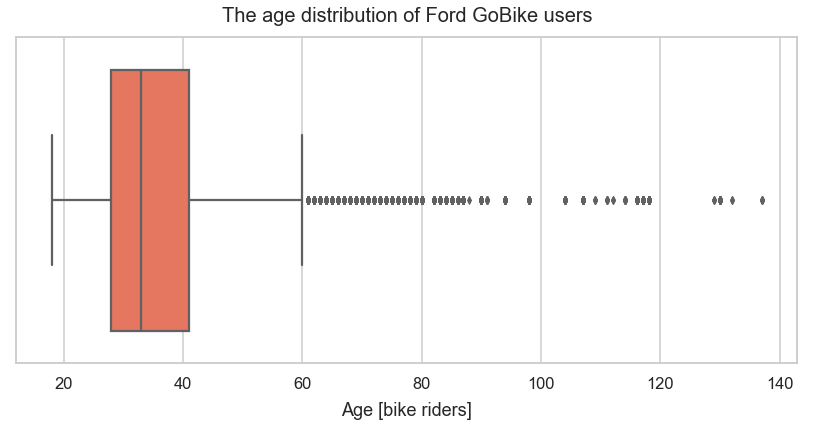

In [4]:
plt.figure(figsize=(14,6))
sns.boxplot(x='member_age', data=df, palette='Reds', orient='h')
plt.title("The age distribution of Ford GoBike users", fontsize=20, y=1.03)
plt.xlabel("Age [bike riders]", fontsize=18, labelpad=10)
plt.savefig('image01.png');

## Monthly Trend of Bike Users

> There is seasonality when the season is winter because it is cold. However, bike rides of July 2017 and 2018 increased more than 5 times. This slide shows us, GoBike program is growing.

In [5]:
#Generate new fields for date from start_time and end_time
df['start_time']=pd.to_datetime(df['start_time'])
df['end_time']=pd.to_datetime(df['end_time'])
df['start_time_date']=df['start_time'].dt.date
df['end_time_date']=df['end_time'].dt.date
df['start_time_year_month']=df['start_time'].map(lambda x: x.strftime('%Y-%m'))
df['end_time_year_month']=df['end_time'].map(lambda x: x.strftime('%Y-%m'))
df['start_time_year_month_renamed'] = df['start_time'].dt.strftime('%y' + '-' + '%m')
df['start_time_year']=df['start_time'].dt.year.astype(int)
df['end_time_year']=df['end_time'].dt.year.astype(int)
df['start_time_month']=df['start_time'].dt.month.astype(int)
df['end_time_month']=df['end_time'].dt.month.astype(int)
df['start_time_hour_minute']=df['start_time'].map(lambda x: x.strftime('%H-%m'))
df['end_time_hour_minute']=df['end_time'].map(lambda x: x.strftime('%H-%m'))
df['start_time_hour']=df['start_time'].dt.hour
df['end_time_hour']=df['end_time'].dt.hour
df['start_time_weekday']=df['start_time'].dt.weekday_name
df['end_time_weekday']=df['end_time'].dt.weekday_name
df['start_time_weekday_abbr']=df['start_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])
df['end_time_weekday_abbr']=df['end_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])

In [6]:
def transform_axis_fmt(tick_val, pos):
    if tick_val >= 1000:
        val = int(tick_val/1000)
        return '{:d}K'.format(val)
    elif tick_val >= 1000000: 
        val = int(tick_val/1000000)
        return '{:d}M'.format(val)
    else:
        return int(tick_val)

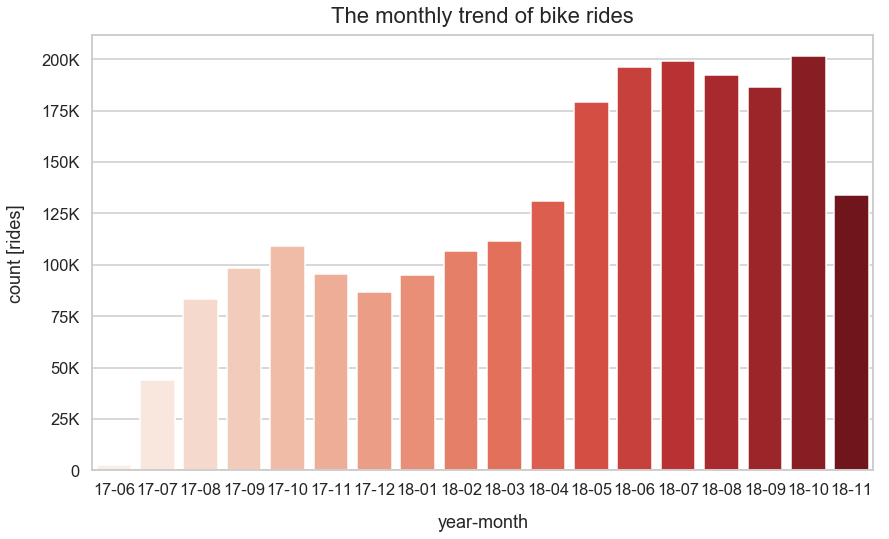

In [7]:
plt.figure(figsize=(14,8))
sns.countplot(x='start_time_year_month_renamed', palette="Reds", data=df.sort_values(by='start_time_year_month_renamed'))
plt.title('The monthly trend of bike rides', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('image03.png')

## Monthly Trend of Age Groups

> 20-30 years old users are rapidly growing compared to other user groups. When the service first started 30-40 years old users were dominant, however 20-30 years old users became leader in a year.

In [8]:
#Generate a new field for member age group from member_age_bin
df['member_age_bins'] = df['member_age'].apply(lambda x: '10 - 20' if 10<x<=20
                                                  else '20 - 30' if 20<x<=30
                                                  else '30 - 40' if 30<x<=40
                                                  else '40 - 50' if 40<x<=50
                                                  else '50 - 60' if 50<x<=60
                                                  else x)

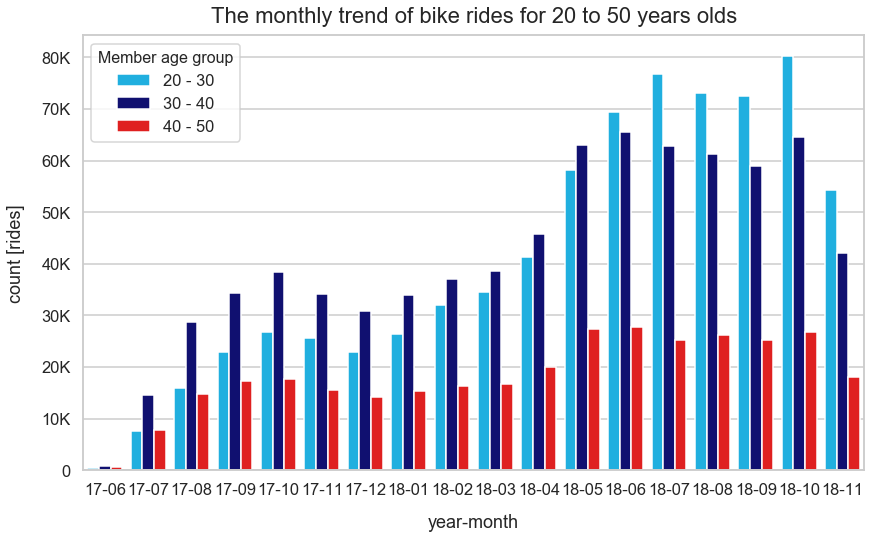

In [9]:
plt.figure(figsize=(14,8))
my_palette = {'20 - 30': 'deepskyblue', '30 - 40': 'navy', '40 - 50': 'red'}
ax = sns.countplot(x='start_time_year_month_renamed', hue='member_age_bins', palette=my_palette, data=df[df['member_age_bins'].isin(['20 - 30', '30 - 40', '40 - 50'])].sort_values(by=['start_time_year_month_renamed', 'member_age_bins']))
plt.title('The monthly trend of bike rides for 20 to 50 years olds', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('Member age group',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('image04.png');

## Gender of Users

In [10]:
trip_by_gender_df = df.groupby('member_gender').agg({'bike_id':'count'})
trip_by_gender_df['perc'] = (trip_by_gender_df['bike_id']/trip_by_gender_df['bike_id'].sum())*100

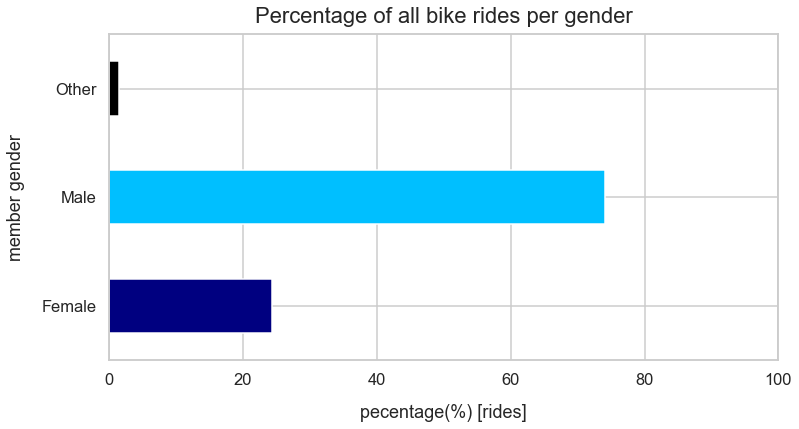

In [13]:
new_color = ['navy', 'deepskyblue', 'black']
trip_by_gender_df['perc'].plot(kind='barh', color=new_color, figsize=(12,6))
plt.title('Percentage of all bike rides per gender', fontsize=22, y=1.015)
plt.ylabel('member gender', labelpad=16)
plt.xlabel('pecentage(%) [rides]', labelpad=16)
plt.xticks(rotation=360)
plt.xlim(0,100)
plt.savefig('image06.png');

## Using Times of GoBike

> Subscribers are most frequently used this service around 7~9am and 4~6pm.
Customers are used this service at weekend around 10am~5pm and weekday 5pm~6pm. Customers use this service during weekend for leisure and weekdays after work.

In [14]:
subscriber_hour_df = df[(df['member_age']>=20) & (df['member_age']<40) 
                              &(df['start_time_hour']>5)&(df['user_type']=='Subscriber')
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [15]:
subscriber_hour_df['start_time_weekday_abbr'] = pd.Categorical(subscriber_hour_df['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)
subscriber_hour_df['count_perc'] = subscriber_hour_df['count'].apply(lambda x: (x/subscriber_hour_df['count'].sum())*100)
subscriber_hour_df['rank'] = subscriber_hour_df['count_perc'].rank(ascending=False).astype(int)
subscriber_hour_df_pivoted = subscriber_hour_df.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank')
customer_hour_df = df[(df['member_age']>=20) & (df['member_age']<40) 
                              &(df['start_time_hour']>5)&(df['user_type']=='Customer') 
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
customer_hour_df['start_time_weekday_abbr'] = pd.Categorical(customer_hour_df['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)
customer_hour_df['count_perc'] = customer_hour_df['count'].apply(lambda x: (x/customer_hour_df['count'].sum())*100) #male
customer_hour_df['rank'] = customer_hour_df['count_perc'].rank(ascending=False).astype(int)
customer_hour_df_pivoted = customer_hour_df.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank').astype(int)

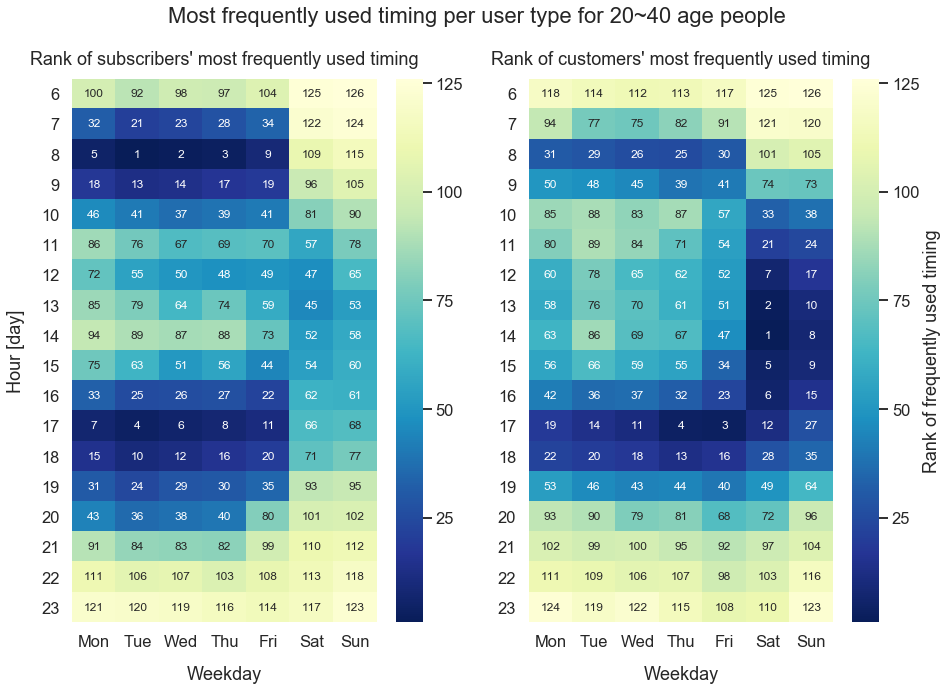

In [16]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.suptitle('Most frequently used timing per user type for 20~40 age people', fontsize=22)
sns.heatmap(subscriber_hour_df_pivoted, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 12})
plt.title("Rank of subscribers' most frequently used timing", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel('Hour [day]', labelpad=16)
plt.yticks(rotation=360)
plt.subplot(122)
sns.heatmap(customer_hour_df_pivoted, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 12}, cbar_kws={'label': 'Rank of frequently used timing'})
plt.title("Rank of customers' most frequently used timing", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)
plt.savefig('image13.png');